# MERSCOPE DEGs Analysis

In [1]:
# Import necessary libraries
import sys
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd # For .parquet file with geometries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # For displaying images
import seaborn as sns
# import squidpy
import warnings
from shapely import wkt
import numpy as np

project_root = "/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation"
sys.path.append(project_root)
from HELPERs.plotting import create_volcano_plot

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.se

In [2]:
os.chdir(project_root)

base_path = 'DATA/p0-p7/R1'
h5ad_file = os.path.join(base_path, 'data.h5ad')

In [3]:
roi_csv_file_name = 'p0_R1_ROI_28-07-25_11-57_geometry.csv'
roi_geometry_file_path = os.path.join(base_path, roi_csv_file_name)
summary_image_file = os.path.join(base_path, 'summary.png')
plot_enable = True

## 1. Data Loading

In [4]:
adata = sc.read_h5ad(h5ad_file)

In [5]:
keep_genes = [x for x in adata.var.index.tolist() if 'Blank' not in x]
print(len(keep_genes))
print(adata.shape[1])

960
960


In [6]:
# Cell boundaries
cell_boundaries_file = os.path.join(base_path, 'cell_boundaries.parquet')
cell_boundaries_gdf = None

In [7]:
cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file)
print(f"Loaded {cell_boundaries_file}. Shape: {cell_boundaries_gdf.shape}")

Loaded DATA/p0-p7/R1/cell_boundaries.parquet. Shape: (319081, 9)


In [8]:
cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
2073005400003100083,220,2073005400003100083,3,"MULTIPOLYGON (((6938.809 5733.381, 6939.235 57...",None,None,cell,6.0,None
2073005400003100083,246,2073005400003100083,2,"MULTIPOLYGON (((6938.809 5733.381, 6939.235 57...",None,None,cell,4.5,None
2073005400003100083,272,2073005400003100083,4,"MULTIPOLYGON (((6938.809 5733.381, 6939.235 57...",None,None,cell,7.5,None
2073005400003100083,298,2073005400003100083,1,"MULTIPOLYGON (((6938.809 5733.381, 6939.235 57...",None,None,cell,3.0,None
2073005400003100083,324,2073005400003100083,5,"MULTIPOLYGON (((6938.809 5733.381, 6939.235 57...",None,None,cell,9.0,None


# Subselect cells based on ROI polygons from CSV

This section loads ROI polygons from a CSV file, converts them to geometries,
and then selects cells from `cell_boundaries_gdf` that fall within these ROIs.

In [9]:
# Load ROI geometry data from CSV
roi_polygons_df = pd.read_csv(roi_geometry_file_path)
print(f"Successfully loaded ROI geometry file: {roi_geometry_file_path}")
print("ROI CSV Head:")
print(roi_polygons_df.head())

Successfully loaded ROI geometry file: DATA/p0-p7/R1/p0_R1_ROI_28-07-25_11-57_geometry.csv
ROI CSV Head:
  EntityID                                           geometry  \
0  tocheck  POLYGON ((6895.4 7889.58, 6888.32 7949.75, 700...   

                                       dataset        group  
0  202504111150_Sessa-p0-p7_VMSC10702_region_4  Unclustered  


# Process ROI geometries and perform spatial selection

In [21]:
# Convert WKT string geometries to Shapely geometry objects
roi_polygons_df['geometry'] = roi_polygons_df['geometry'].apply(wkt.loads)

# Create a GeoDataFrame from the ROI data
# Assume cell_boundaries_gdf is already defined and has a CRS.
# If cell_boundaries_gdf.crs is None, roi_gdf.crs will also be None,
# which is acceptable if coordinates are in the same arbitrary Cartesian system.
current_crs = None
if 'cell_boundaries_gdf' in locals() and cell_boundaries_gdf is not None and hasattr(cell_boundaries_gdf, 'crs'):
    current_crs = cell_boundaries_gdf.crs
    print(f"Using CRS from cell_boundaries_gdf: {current_crs}")
else:
    print("Warning: cell_boundaries_gdf not found or has no CRS. Assuming planar coordinates for ROIs.")

TypeError: Expected bytes or string, got Polygon

In [ ]:
roi_gdf = gpd.GeoDataFrame(roi_polygons_df, geometry='geometry', crs=current_crs)
print("Successfully converted ROI geometries to GeoDataFrame.")
print("ROI GeoDataFrame Head:")
roi_gdf.head()

Successfully converted ROI geometries to GeoDataFrame.
ROI GeoDataFrame Head:


,EntityID,geometry,dataset,group
0,tocheck,"POLYGON ((6895.400 7889.580, 6888.320 7949.750...",202504111150_Sessa-p0-p7_VMSC10702_region_4,Unclustered


In [ ]:
# Perform spatial selection of cells within ROIs
print(f"Shape of cell_boundaries_gdf before spatial join: {cell_boundaries_gdf.shape}")
print(f"Shape of roi_gdf before spatial join: {roi_gdf.shape}")

Shape of cell_boundaries_gdf before spatial join: (319081, 9)
Shape of roi_gdf before spatial join: (1, 4)


In [ ]:
# Prepare the left GeoDataFrame for sjoin to avoid 'EntityID' column clash
# The original cell_boundaries_gdf has 'EntityID' as both index and column.
# Renaming the index ensures that when sjoin (or its internal functions)
# calls reset_index(), the new column from the index doesn't conflict.
cell_boundaries_gdf_sjoin_ready = cell_boundaries_gdf.copy()
cell_boundaries_gdf_sjoin_ready.index.name = 'original_cell_EntityID_idx' # Rename the index

In [ ]:
# Spatial join: find cells whose geometries are 'within' the ROI polygons
# 'how="inner"' means only cells that are within an ROI are kept.
# 'predicate="within"' checks if cell geometry is entirely within ROI geometry.
# Added lsuffix and rsuffix to handle any potential column name overlaps clearly.
cells_in_rois_gdf = gpd.sjoin(
    cell_boundaries_gdf_sjoin_ready,
    roi_gdf,
    how="inner",
    predicate="within",
    lsuffix='_cell',
    rsuffix='_roi'
)

In [ ]:
cells_in_rois_gdf.head()

,ID,EntityID__cell,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name,index__roi,EntityID__roi,dataset,group
original_cell_EntityID_idx,,,,,,,,,,,,,
2073005400043101200,132623,2073005400043101200,3,"MULTIPOLYGON (((6951.595 7926.438, 6952.305 79...",None,None,cell,6.0,None,0,tocheck,202504111150_Sessa-p0-p7_VMSC10702_region_4,Unclustered
2073005400043101208,132630,2073005400043101208,3,"MULTIPOLYGON (((6918.725 7932.589, 6919.615 79...",None,None,cell,6.0,None,0,tocheck,202504111150_Sessa-p0-p7_VMSC10702_region_4,Unclustered
2073005400043101211,132633,2073005400043101211,3,"MULTIPOLYGON (((6906.493 7930.563, 6908.167 79...",None,None,cell,6.0,None,0,tocheck,202504111150_Sessa-p0-p7_VMSC10702_region_4,Unclustered
2073005400043101227,132643,2073005400043101227,3,"MULTIPOLYGON (((7030.753 7936.631, 7032.026 79...",None,None,cell,6.0,None,0,tocheck,202504111150_Sessa-p0-p7_VMSC10702_region_4,Unclustered
2073005400043101230,132645,2073005400043101230,3,"MULTIPOLYGON (((6917.316 7940.937, 6918.756 79...",None,None,cell,6.0,None,0,tocheck,202504111150_Sessa-p0-p7_VMSC10702_region_4,Unclustered


In [ ]:
print(f"\nFound {cells_in_rois_gdf.shape[0]} cells within the defined ROIs.")


Found 469 cells within the defined ROIs.


In [ ]:
print("Head of cells_in_rois_gdf (cells spatially selected by ROIs):")
print(cells_in_rois_gdf.head())

Head of cells_in_rois_gdf (cells spatially selected by ROIs):
                                ID       EntityID__cell  ZIndex  \
original_cell_EntityID_idx                                        
2073005400043101200         132623  2073005400043101200       3   
2073005400043101208         132630  2073005400043101208       3   
2073005400043101211         132633  2073005400043101211       3   
2073005400043101227         132643  2073005400043101227       3   
2073005400043101230         132645  2073005400043101230       3   

                                                                     Geometry  \
original_cell_EntityID_idx                                                      
2073005400043101200         MULTIPOLYGON (((6951.595 7926.438, 6952.305 79...   
2073005400043101208         MULTIPOLYGON (((6918.725 7932.589, 6919.615 79...   
2073005400043101211         MULTIPOLYGON (((6906.493 7930.563, 6908.167 79...   
2073005400043101227         MULTIPOLYGON (((7030.753 7936.631, 

In [ ]:
# Analyze the selected cells
print("\nCell counts per ROI:")
print(cells_in_rois_gdf.groupby('group').size())


Cell counts per ROI:
group
Unclustered    469
dtype: int64



Cell counts per ROI group (from 'group' column of ROI CSV):
group
Unclustered    469
dtype: int64

Plotting selected cells and ROIs...


/tmp/ipykernel_1952795/2052724004.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


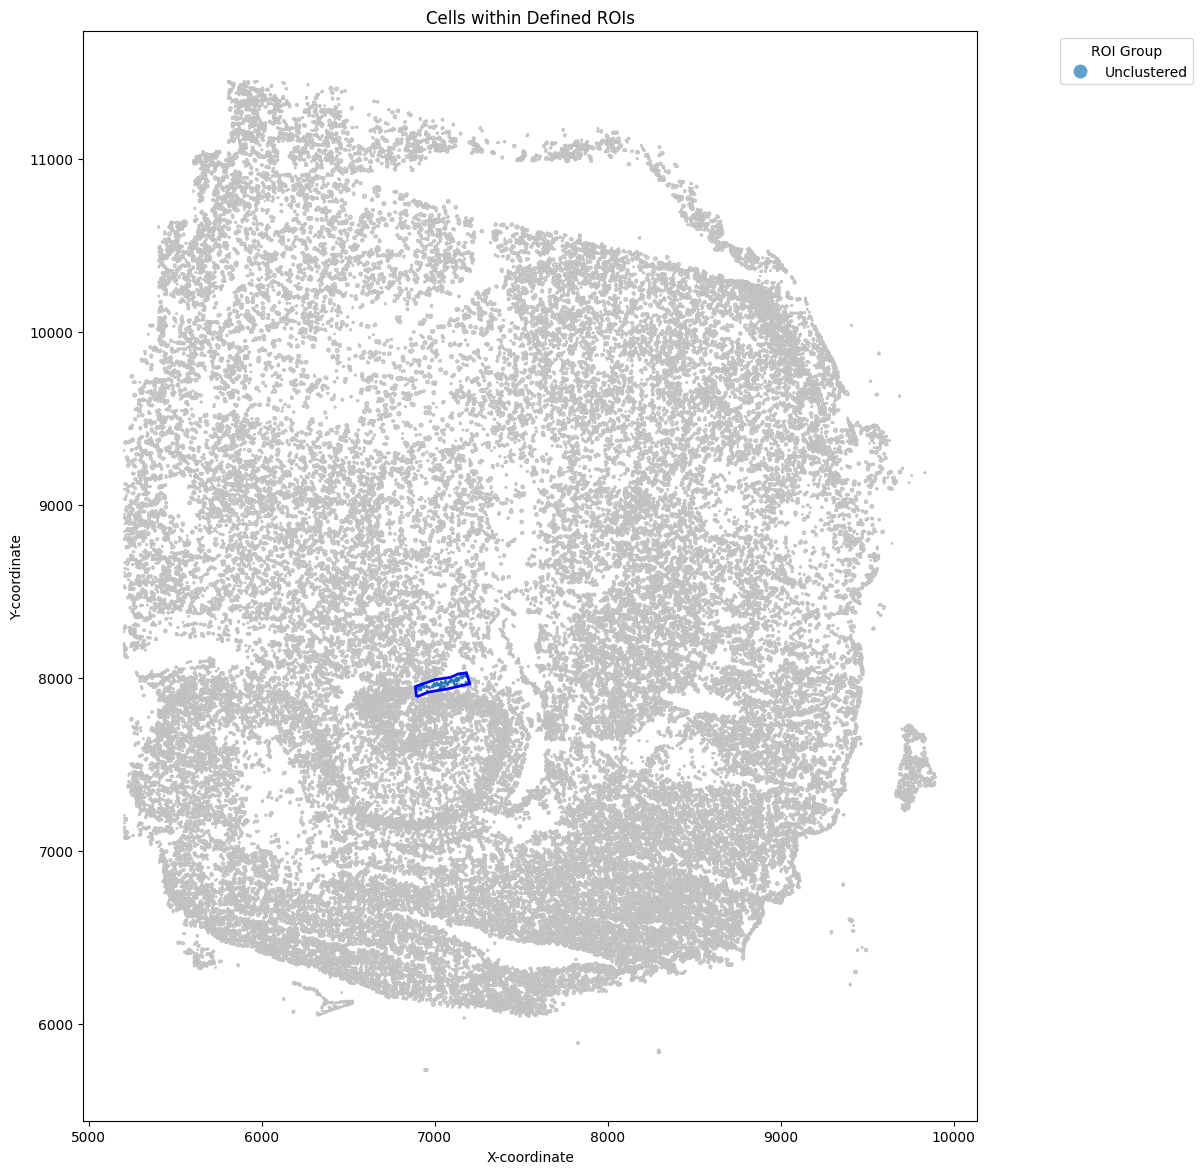

In [ ]:
# Visualize selected cells with ROIs

if plot_enable:

    print("\nCell counts per ROI group (from 'group' column of ROI CSV):")
    print(cells_in_rois_gdf.groupby('group').size())

    print("\nPlotting selected cells and ROIs...")
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot all original cell boundaries lightly
    cell_boundaries_gdf.plot(ax=ax, color='lightgray', edgecolor='silver', alpha=0.3, label='All Cells (Original)')

    unique_groups = cells_in_rois_gdf['group'].nunique()
    cells_in_rois_gdf.plot(ax=ax, column='group', legend=True, alpha=0.7, categorical=True,
                                           legend_kwds={'title': "ROI Group", 'loc': 'upper right', 'bbox_to_anchor': (1.25, 1)})

    # Plot ROI boundaries
    roi_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='ROI Polygons')

    ax.set_title("Cells within Defined ROIs")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")

    # Adjust legend display
    handles, labels = ax.get_legend_handles_labels()

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

<img src="2025-07-28 19_12_21-MERSCOPE Vizualizer (p0_R1).png" alt="MERSCOPE Vizualizer">

# 2. Analyze transcript expression directly within ROIs

Loading transcripts from DATA/p0-p7/R1/detected_transcripts.csv...
Loaded 6250406 transcripts.
Successfully converted transcripts to GeoDataFrame.

Found 6978 transcripts within all ROIs.

--- Analysis for ROI Group: Unclustered ---
Total transcripts in this ROI group: 6978
Top 20 most expressed genes:
gene
Ubc        553
Gfap       428
Sparcl1    389
Zbtb20     218
Nfib       205
Atp1a2     152
Gria2      106
Gabbr1      80
Ptprs       77
Nfia        77
Grik2       70
Vim         66
Cdh5        58
Slc1a2      51
Col3a1      49
Nlgn2       49
Flna        47
Axin2       46
Huwe1       44
Sox11       43
Name: count, dtype: int64


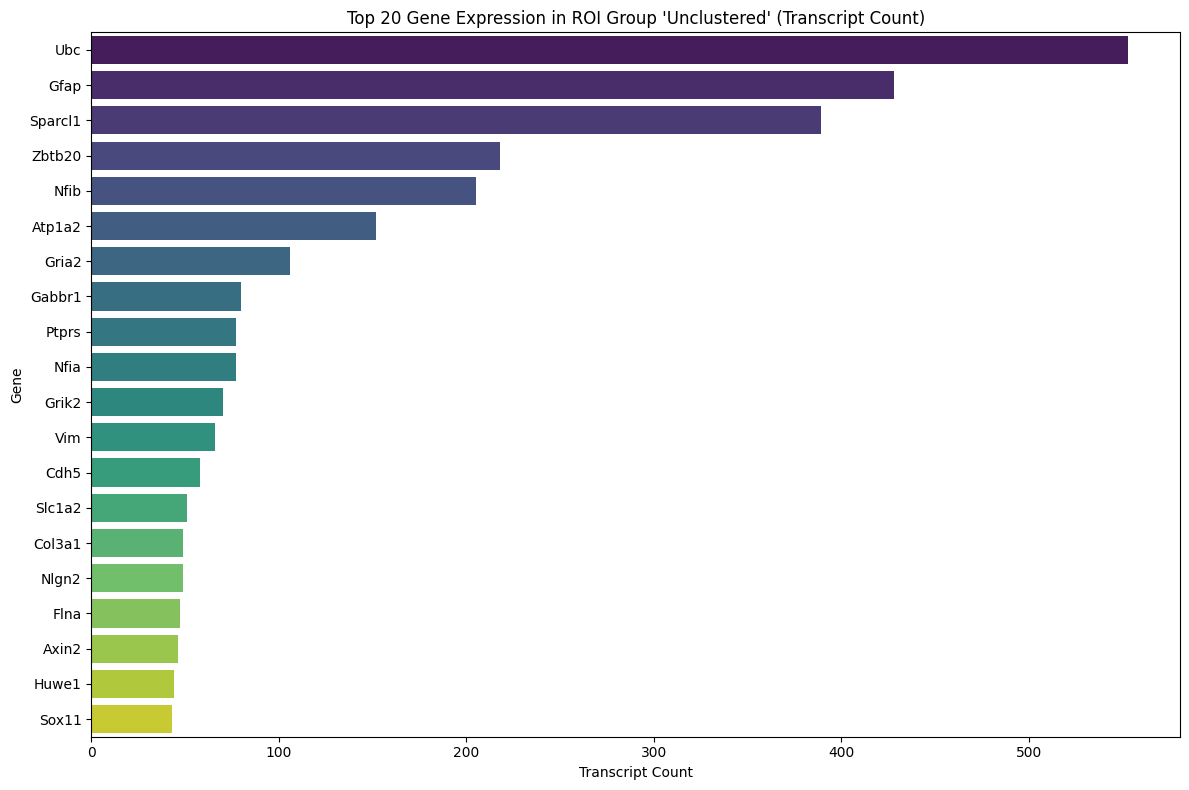

In [20]:
# Load transcript data
# The transcript file is typically named 'detected_transcripts.csv' in Vizgen datasets.
transcripts_file = os.path.join(base_path, 'detected_transcripts.csv')
if os.path.exists(transcripts_file):
    print(f"Loading transcripts from {transcripts_file}...")
    transcripts_df = pd.read_csv(transcripts_file)
    print(f"Loaded {len(transcripts_df)} transcripts.")
    
    # Convert transcripts DataFrame to a GeoDataFrame
    # MERSCOPE data uses 'global_x' and 'global_y' for coordinates.
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df,
        geometry=gpd.points_from_xy(transcripts_df['global_x'], transcripts_df['global_y']),
        crs=current_crs  # Use the same CRS as the cell boundaries
    )
    print("Successfully converted transcripts to GeoDataFrame.")

    # Spatially join transcripts with ROIs
    transcripts_in_rois_gdf = gpd.sjoin(transcripts_gdf, roi_gdf, how="inner", predicate="within")
    
    print(f"\nFound {len(transcripts_in_rois_gdf)} transcripts within all ROIs.")

    # Analyze and plot gene expression for each ROI group
    for group_name, group_df in transcripts_in_rois_gdf.groupby('group'):
        print(f"\n--- Analysis for ROI Group: {group_name} ---")
        
        # Get gene counts
        gene_counts = group_df['gene'].value_counts()
        
        print(f"Total transcripts in this ROI group: {len(group_df)}")
        print("Top 20 most expressed genes:")
        print(gene_counts.head(20))
        
        # Plotting
        if plot_enable:
            plt.figure(figsize=(12, 8))
            sns.barplot(x=gene_counts.head(20).values, y=gene_counts.head(20).index, palette="viridis")
            plt.title(f"Top 20 Gene Expression in ROI Group '{group_name}' (Transcript Count)")
            plt.xlabel("Transcript Count")
            plt.ylabel("Gene")
            plt.tight_layout()
            plt.show()
else:
    print(f"Transcript file not found at: {transcripts_file}")
    print("Skipping transcript-level analysis.")